# Data Collection and Preprocessing

**Importing Libraries**

In [124]:
from nba_api.stats.endpoints import leaguedashteamstats
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
import statsmodels.api as sm

**Loading in Data (Looking at one year of data looks like)**

In [125]:
data =  leaguedashteamstats.LeagueDashTeamStats(season='2023-24',measure_type_detailed_defense='Advanced')#Focusing more on advanced stats
datadf = data.get_data_frames()[0]
datadf.head()


,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,E_OFF_RATING,OFF_RATING,E_DEF_RATING,...,AST_TO_RANK,AST_RATIO_RANK,OREB_PCT_RANK,DREB_PCT_RANK,REB_PCT_RANK,TM_TOV_PCT_RANK,EFG_PCT_RANK,TS_PCT_RANK,PACE_RANK,PIE_RANK
0,1611661330,Atlanta Dream,40,19,21,0.475,1610.0,97.2,99.7,99.2,...,70,71,49,16,32,68,71,71,44,49
1,1610612737,Atlanta Hawks,87,39,48,0.448,4171.0,113.5,115.9,116.2,...,21,37,14,26,25,15,31,46,26,54
2,1612709890,Austin Spurs,34,20,14,0.588,1637.0,114.0,111.6,110.7,...,63,53,41,23,21,58,21,6,18,16
3,1612709913,Birmingham Squadron,34,15,19,0.441,1634.0,119.9,117.2,121.6,...,28,26,36,72,64,28,13,3,23,48
4,1610612738,Boston Celtics,87,66,21,0.759,4166.0,119.2,121.3,108.7,...,3,15,35,14,11,2,2,8,49,4


**Creating Dataframe of Team Data from the last 5 years(Not including the two COVID shortened seasons since the difference in games played will mess up season wins predictor models)**

In [126]:
seasons = ['2023-24','2022-23','2021-22','2018-19','2017-18'] #Seasons going to be used in training and testing process

dfs = []
for season in seasons:
    stats = leaguedashteamstats.LeagueDashTeamStats(season=season,measure_type_detailed_defense='Advanced',league_id_nullable = '00')
    statsdf = stats.get_data_frames()[0]
    statsdf.insert(loc = 0 , column = 'SEASON', value=season)
    dfs.append(statsdf)

NBA_df = pd.concat(dfs, ignore_index= True) #Combining all the seasons into one dataframe
NBA_df

,SEASON,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,E_OFF_RATING,OFF_RATING,...,AST_TO_RANK,AST_RATIO_RANK,OREB_PCT_RANK,DREB_PCT_RANK,REB_PCT_RANK,TM_TOV_PCT_RANK,EFG_PCT_RANK,TS_PCT_RANK,PACE_RANK,PIE_RANK
0,2023-24,1610612737,Atlanta Hawks,82,36,46,0.439,3971.0,114.0,116.4,...,18,21,5,16,12,13,17,18,6,22
1,2023-24,1610612738,Boston Celtics,82,64,18,0.780,3966.0,120.2,122.2,...,3,13,14,7,5,1,2,1,19,1
2,2023-24,1610612751,Brooklyn Nets,82,32,50,0.390,3961.0,110.4,112.4,...,19,19,12,19,20,14,25,27,25,21
3,2023-24,1610612766,Charlotte Hornets,82,21,61,0.256,3946.0,107.1,108.6,...,25,22,27,22,29,21,26,28,22,29
4,2023-24,1610612741,Chicago Bulls,82,39,43,0.476,3996.0,112.4,114.0,...,13,24,11,17,14,3,22,21,28,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2017-18,1610612758,Sacramento Kings,82,27,55,0.329,3951.0,101.1,103.1,...,20,23,17,15,27,14,27,30,30,29
146,2017-18,1610612759,San Antonio Spurs,82,47,35,0.573,3946.0,105.5,107.1,...,6,13,9,8,8,6,26,25,28,6
147,2017-18,1610612761,Toronto Raptors,82,59,23,0.720,3966.0,111.0,113.0,...,4,6,12,21,15,4,5,4,14,3
148,2017-18,1610612762,Utah Jazz,82,48,34,0.585,3951.0,106.2,107.4,...,24,17,21,3,7,24,9,11,25,4


In [127]:
import numpy as np
np.unique(NBA_df['SEASON'])

array(['2017-18', '2018-19', '2021-22', '2022-23', '2023-24'],
      dtype=object)

**Visualizing Team Wins Distributions Across Seasons**

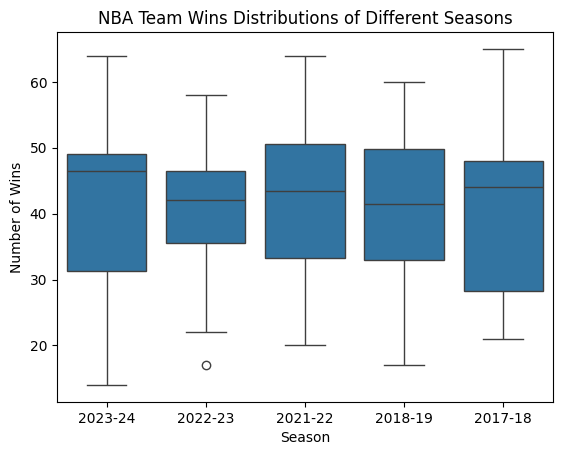

In [128]:
sns.boxplot(x = 'SEASON', y= 'W',data= NBA_df)
plt.title('NBA Team Wins Distributions of Different Seasons')
plt.xlabel('Season')
plt.ylabel('Number of Wins')
plt.show()

The IQR and median for a team's wins in the NBA look to be similar across these 5 seasons

**Taking Out Irrelevant Metrics that do not make sense to use for wins predictions**

In [129]:
NBA_df.columns #Looking at all the metrics in this dataframe to see which ones are irrelevant and not needed

Index(['SEASON', 'TEAM_ID', 'TEAM_NAME', 'GP', 'W', 'L', 'W_PCT', 'MIN',
       'E_OFF_RATING', 'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING',
       'E_NET_RATING', 'NET_RATING', 'AST_PCT', 'AST_TO', 'AST_RATIO',
       'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT',
       'E_PACE', 'PACE', 'PACE_PER40', 'POSS', 'PIE', 'GP_RANK', 'W_RANK',
       'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'OFF_RATING_RANK',
       'DEF_RATING_RANK', 'NET_RATING_RANK', 'AST_PCT_RANK', 'AST_TO_RANK',
       'AST_RATIO_RANK', 'OREB_PCT_RANK', 'DREB_PCT_RANK', 'REB_PCT_RANK',
       'TM_TOV_PCT_RANK', 'EFG_PCT_RANK', 'TS_PCT_RANK', 'PACE_RANK',
       'PIE_RANK'],
      dtype='object')

In [130]:
NBA_df = NBA_df.drop(['SEASON','TEAM_ID','TEAM_NAME','GP','L','W_PCT','MIN','GP_RANK','W_RANK','L_RANK','W_PCT_RANK','MIN_RANK','E_NET_RATING','NET_RATING'], axis = 1) 
#Getting rid of columns not needed or interfere with wins predictions

print("Number of Columns Left: ",len(NBA_df.columns)) #Amount of metrics left

NBA_df.columns

Number of Columns Left:  33


Index(['W', 'E_OFF_RATING', 'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING',
       'AST_PCT', 'AST_TO', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT', 'REB_PCT',
       'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'E_PACE', 'PACE', 'PACE_PER40',
       'POSS', 'PIE', 'OFF_RATING_RANK', 'DEF_RATING_RANK', 'NET_RATING_RANK',
       'AST_PCT_RANK', 'AST_TO_RANK', 'AST_RATIO_RANK', 'OREB_PCT_RANK',
       'DREB_PCT_RANK', 'REB_PCT_RANK', 'TM_TOV_PCT_RANK', 'EFG_PCT_RANK',
       'TS_PCT_RANK', 'PACE_RANK', 'PIE_RANK'],
      dtype='object')

**Checking for any empty values**

In [131]:
sum(NBA_df.isnull().sum()) #Finds and counts up anywhere there is an empty value, it appears there are no empty values

0

**Notable NBA team averages over past 5 non-COVID seasons**

In [132]:
avg = NBA_df.mean()
print('NBA team averages the past 5 non-COVID seasons')
pd.DataFrame(avg).iloc[1:21,:]

NBA team averages the past 5 non-COVID seasons


,0
E_OFF_RATING,109.604000
OFF_RATING,111.513333
E_DEF_RATING,109.592667
DEF_RATING,111.503333
AST_PCT,0.605213
AST_TO,1.792067
AST_RATIO,18.003333
OREB_PCT,0.275313
DREB_PCT,0.724293
REB_PCT,0.499960


**Establishing Input and Target Variables**

In [133]:
X = NBA_df.drop('W', axis = 1) #Basically the dataframe with all the metrics except wins(the target variable)
y = NBA_df['W']


**Standardizing Input Features**

In [134]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X

array([[ 1.10965351,  1.23004066,  1.9596556 , ...,  0.28883564,
        -1.0968174 ,  0.75097267],
       [ 2.67467893,  2.68997977, -0.16341186, ..., -1.67524673,
         0.40620012, -1.67524673],
       [ 0.20092907,  0.22318609,  0.96705263, ...,  1.32864396,
         1.09990051,  0.63543842],
       ...,
       [ 0.35238314,  0.37421428, -1.70746092, ..., -1.32864396,
        -0.17188354, -1.44417822],
       [-0.85924944, -1.03538211, -2.20376241, ..., -0.51990416,
         1.09990051, -1.32864396],
       [-0.68255302, -0.85918256, -0.93543639, ..., -0.4043699 ,
         0.05934992, -0.28883564]])

**Visualizing Relationships Between Well Known Metrics and Season Wins**

OFF_RATING = Offensive Rating, which measures amount of points a team scores every 100 possessions

DEF_RATING = Defensive Rating, which measures amount of points a team gets scored on every 100 possessions

TM_TOV_PCT = Team turnover percentage, which indicates the percentage of possesions a team gets that end up being a turnover

AST_TO = The ratio Assists/Turnovers, a high ratio indicates efficient passing and ball handling

PACE = Amount of possessions a team gets per 48 minutes, it indicates how fast a team plays

The subsequent rank statistic indicates the best and worst teams for each stat in a given season (1st indicating best performing team and 30th indicating worst when looking at unscaled data)


In [135]:
NBA_df['POSS']

0      8339
1      8090
2      8050
3      8047
4      8078
       ... 
145    7860
146    7867
147    8104
148    7951
149    8087
Name: POSS, Length: 150, dtype: int64

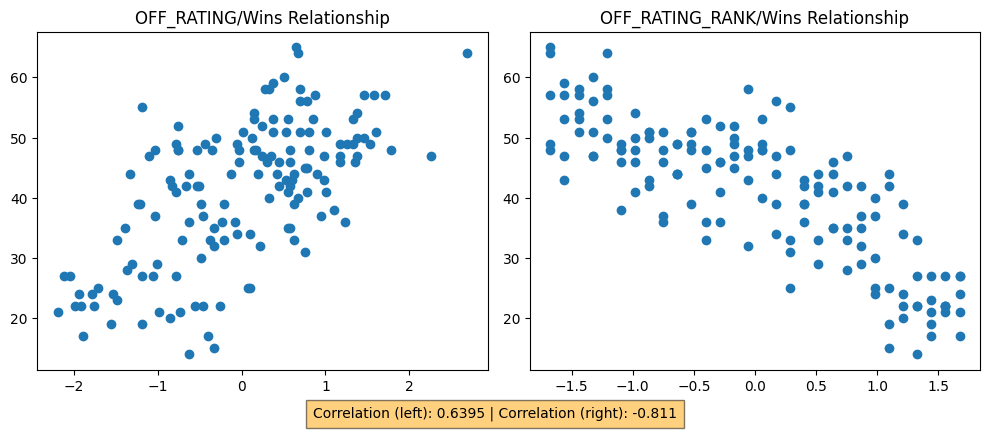

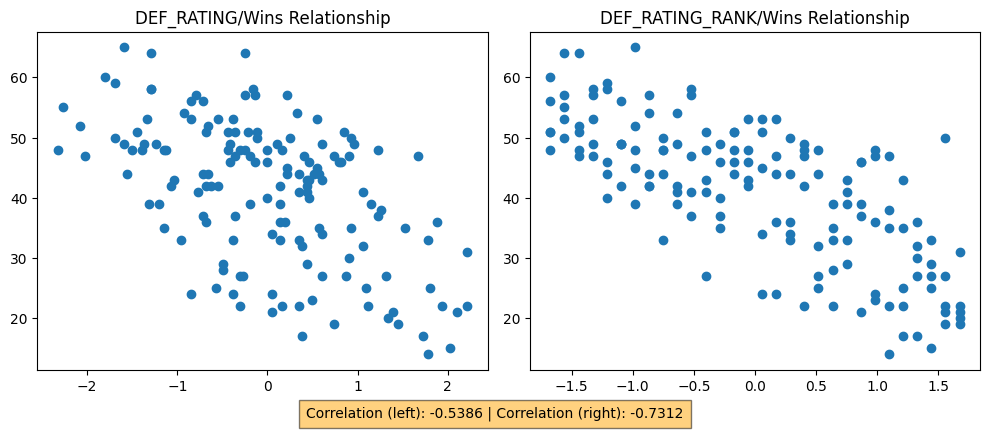

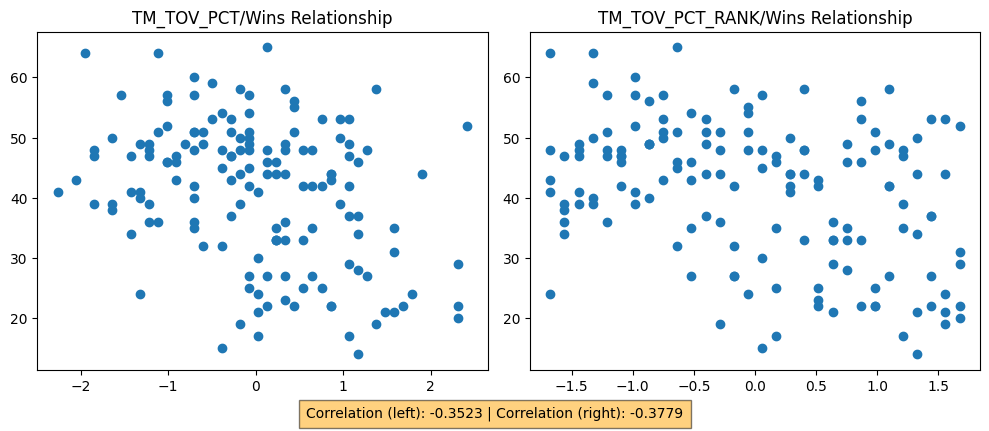

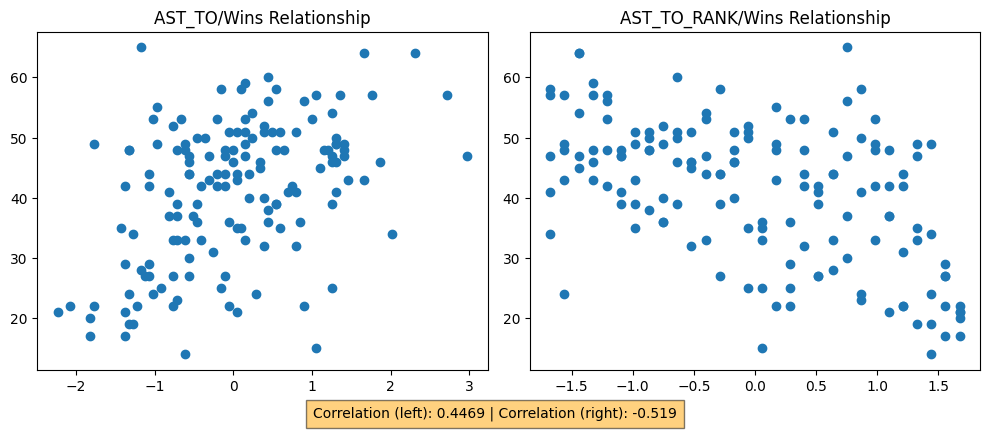

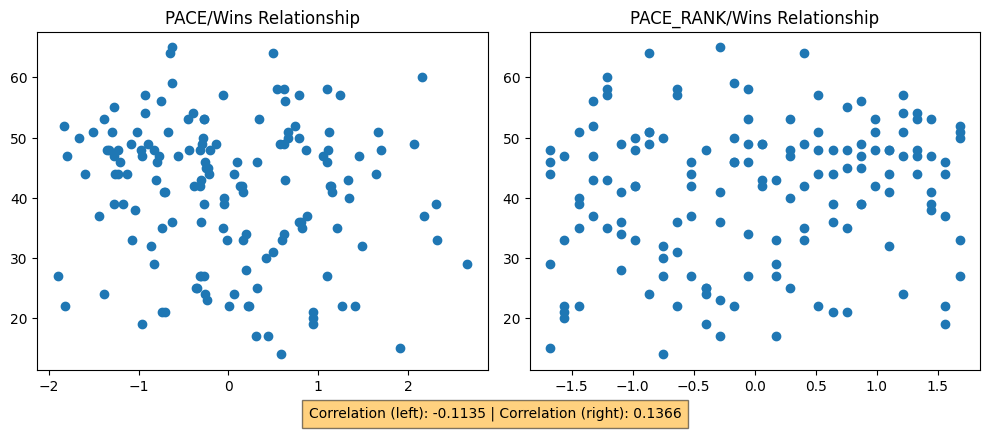

In [136]:
scaled_df = pd.DataFrame(X, columns=NBA_df.columns[1:]) 
#When creating plots using matplotlib, it will be easier to implement if the variables are stored in a dataframe with clearly labeled columns
#compared to a numpy array

metrics = ['OFF_RATING', 'DEF_RATING','TM_TOV_PCT','AST_TO','PACE']
ranked_metrics = [i + '_RANK' for i in metrics]

#Creating relationship plots for specified metrics and their ranked version counterpart
for i in range(len(metrics)):
    fig, ax = plt.subplots(1,2, figsize = (10,4.5))
    ax[0].scatter(scaled_df[metrics[i]],y)
    ax[0].set_title(str(metrics[i])+"/Wins Relationship")

    ax[1].scatter(scaled_df[ranked_metrics[i]],y)
    
    ax[1].set_title(str(ranked_metrics[i])+"/Wins Relationship")
    corr1 = scaled_df[metrics[i]].corr(y)
    corr2 = scaled_df[ranked_metrics[i]].corr(y)
    fig.text(0.5, 0.01, f'Correlation (left): {round(corr1,4)} | Correlation (right): {round(corr2,4)}', ha='center', fontsize=10, bbox={"facecolor": "orange", "alpha": 0.5, "pad": 5})

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])#Prevents overlap between correlation box and plots



It appears Offensive and Defensive Ratings/Rank have somewhat strong linear correlations. TM_TOV_PCT and PACE have weaker correlation coefficients, especially PACE at -.1135 which indicates there is little or no linear correlation between that stat and season wins.

**Using Random Forests and The Gini Importance Metric For Feature Selection**

With there being 32 possible input features that can be used with my model, it will be smart to use some dimensionality reduction method to prevent overfitting. To implement dimensionality reduction and find which features are most important for predicting season wins, I will be using Random Forests and using the Gini importance metric generated by the Random Forest algorithm.

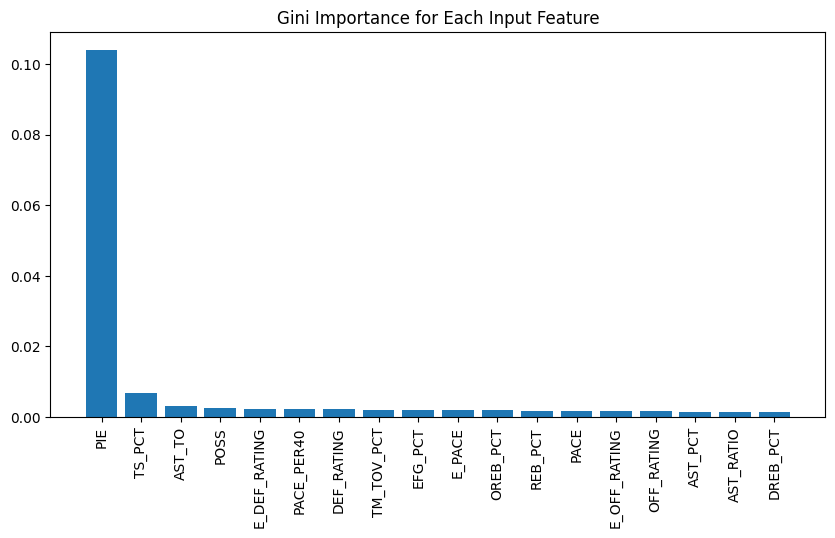

[('PIE', 0.10388330361335657), ('TS_PCT', 0.006746410372442839), ('AST_TO', 0.003107504287274533), ('POSS', 0.0024250605475893226), ('E_DEF_RATING', 0.002304914349886474)]


In [137]:
forest = RandomForestRegressor(random_state=100) #Using random state for reproducability
forest.fit(X,y)
importance = forest.feature_importances_

#Ordering the gini importance scores in descending order
feature_importance = list(zip(importance,NBA_df.drop('W', axis=1).columns))
feature_importance.sort(reverse= True)

importance_lst = []
feature_lst = []
for i,j in feature_importance:
    if 'RANK' in j: #For this project I want to focus on quantitative metrics and not categorical, so I'm taking out the rank metrics
        continue
    importance_lst.append(i)
    feature_lst.append(j)

#Plotting gini importance of the features in a bar graph
plt.figure(figsize=(10,5))
plt.bar(range(len(importance_lst)), importance_lst)
plt.xticks(range(len(feature_lst)),feature_lst, rotation = 90)
plt.title('Gini Importance for Each Input Feature')
plt.show()
print(list(zip(feature_lst[:5],importance_lst[:5])))

**Team PIE(Player Impact Estimate), TS_PCT (True Shooting Percentage),AST_TO(Assist/Turnover Ratio), and POSS () appear to have the biggest gini importance scores for predicting an NBA team's season wins so I will be using these features to create my predictive model**

PIE is the ratio of all the stats a player garners in a game to the total game stats. A higher PIE indicates a more impactful player. Team PIE is just the aggreate PIE of all the players on the team. According to the NBA website a player with a PIE above 10% is more likely to be an above average player and teams with a PIE above 50% are more likely to be a winning team. The website also points out a high PIE is very correlated to a teams winning percentage

True Shooting Percentage (TS_PCT) measures the scoring efficiency of a team or player. It penalizes field goal attempts and to a less extent free throw attempts so players who score a lot on not too many shots taken will have a high true shooting percentage

AST_TO is the ratio between assists and turnovers and is a good indicator of how much care a team is able to take care of the ball when they have possession of it.

POSS represents the estimated amount of possessions a team had throughout the season, maybe this stat can help determine if it better to have focus more on having a lot of quick possessions or less and slower(possibly higher quality) possessions. This could indicate how well a team's defense is (better defense including more steals can lead to more possessions)

# Using Support Vector Regression (SVR) to build NBA season wins prediciting model

**To hyperparameter tune the model, I will be using grid search to test different combinations of model parameters and use cross-validation to determine the best combination. Grid search can be computationally heavy due to the nature of testing all possible combinations, but in the context of this task we will only be tuning 3 combinations so it shouldn't be too computationally heavy.**

In [138]:
#Initializing the SVR model
svr = SVR()

#Creating Input Variable with only selected features chosed above
features = ['AST_TO','POSS','PIE','TS_PCT']
X = NBA_df[features]
y = NBA_df['W']

#Creating Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

#Standardizing Input Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Possible parameter values
params = {'kernel': ['linear','poly','rbf'], #rbf kernel maps the inputs in a higher dimensional space to try and find linear relationships where you wouldn't be able to find them in lower dimensions
          'C':[.01, .1, 1, 5, 10, 50, 100],#Determines penalty of errors outside epsilon range, there is the tradeoff between complexity and generalizability
                                            #Higher C values could lead to overfitting
          'epsilon': [.001,.01,.1,1], #Determines range of which errors are considered significant and which ones are negligible
          'degree': [2,3,4,5,6]#For polynomial kernel only
          }

#Initializing Grid Search
grid = GridSearchCV(svr,params,refit=True, cv = 5, scoring='neg_mean_squared_error', verbose =1)#Using cross-validation and mse to determine best hyperparameters
grid.fit(X_train_scaled,y_train)#Finding best hyperparameters

#Showing best combination of hyperparameters

print('Best combination of hyperparameters: ', grid.best_params_) #Degree parameter doesn't matter since best kernel turns out to be the linear one
print('Current best model:', grid.best_estimator_)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits
Best combination of hyperparameters:  {'C': 100, 'degree': 2, 'epsilon': 0.1, 'kernel': 'linear'}
Current best model: SVR(C=100, degree=2, kernel='linear')


**Finding More Precise Hyperparameter Values**

In [139]:
params_precise = {'kernel': ['linear'],
                  'C': [10,25,50,75,100,125,150,200],
                  'epsilon':  [.0001,.0005,.001,.005,.01,.1,.5,1]
}
grid_precise = GridSearchCV(svr,params_precise,refit=True, cv = 5, scoring='neg_mean_squared_error', verbose =1)
grid_precise.fit(X_train_scaled,y_train)

print('More Precise combination of hyperparameters: ', grid_precise.best_params_)
print('Model to be used:',grid_precise.best_estimator_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
More Precise combination of hyperparameters:  {'C': 125, 'epsilon': 0.1, 'kernel': 'linear'}
Model to be used: SVR(C=125, kernel='linear')


With C = 125 and epsilon = .1 the SVR model is essentially acting as a linear regression model that penalizes errors much harder than a conventional linear regression model.

**Making Predictions and Evaluating Accuracy of Tuned SVR model**

In [140]:
svr_model = grid_precise.best_estimator_

#Storing Model Predictions
y_pred = svr_model.predict(X_test_scaled)

mae = mean_absolute_error(y_test,y_pred)
mse = mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)

metrics_dict = {'Metrics': ['Mean Absolute Error', 'Mean Squared Error', 'Root MSE', "R^2 score"], 'Model Values':[mae,mse,rmse,r2]}
metrics_df = pd.DataFrame(metrics_dict)
metrics_df

,Metrics,Model Values
0,Mean Absolute Error,2.805217
1,Mean Squared Error,13.662612
2,Root MSE,3.696297
3,R^2 score,0.902386


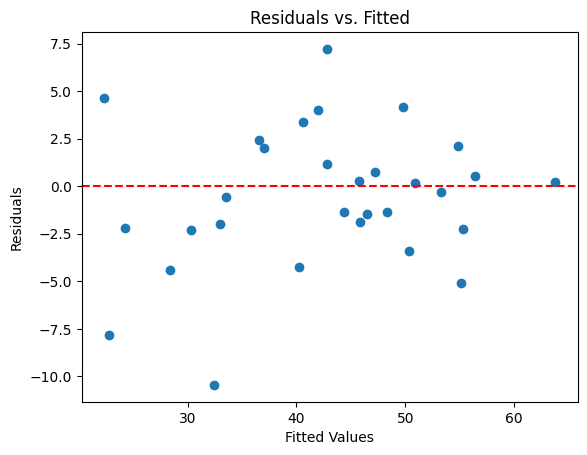

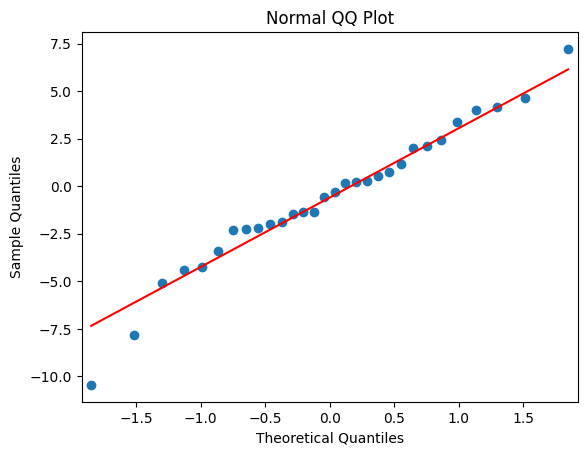

In [141]:
residuals = y_test - y_pred

plt.scatter(y_pred,residuals)
plt.axhline(0, color='red', linestyle = '--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')

sm.qqplot(residuals,line='s')
plt.title('Normal QQ Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

The model appears to fit very well on the data. As desired the residuals vs. fitted plot shows random scattered centered around 0. The QQ plot resembles a very straight line as expected for most quantiles except only for the left tail end.

Also the model appears to be very accurate on the test set. Mean absolute error (MAE) and root mean sqaure error (RMSE) both measure the average error size of the model with RMSE giving a bigger penalty to larger errors. With an MAE score of 2.8 and RMSE of 3.7 that means the model predicts the wins of an NBA team within an average error of 2.38-3.07 wins which is pretty accurate considering there are 82 games in a given season. 

R^2 scores range from 0 to 1 and measure how well a model fits to the data with a score of 1 indicating the model perfectly predicts the target variable based on the inputs and a score of 0 indicating the model can't predict the target variable at all. An R^2 score of .902 is considered a very high score indicating that this model does a great job of predicting the target variable (season wins) based on the input variables given to the model.

**Testing Model on NBA 2016-17 Season**

In [142]:
#Creating dataframe for 2016-17 season
NBA1617_stats = leaguedashteamstats.LeagueDashTeamStats(season='2016-17',measure_type_detailed_defense='Advanced',league_id_nullable='00')
df1617 = NBA1617_stats.get_data_frames()[0]
X1617 = df1617[features]
y = df1617['W']

#Standardizing Inputs
scaler = StandardScaler()
X1617_scaled = scaler.fit_transform(X1617)

#Making Predictions
y1617_pred = svr_model.predict(X1617_scaled)

mae = mean_absolute_error(y,y1617_pred)
mse = mean_squared_error(y,y1617_pred)
rmse = root_mean_squared_error(y,y1617_pred)
r2 = r2_score(y,y1617_pred)

metrics_dict1617 = {'Metrics': ['Mean Absolute Error', 'Mean Squared Error', 'Root MSE', "R^2 score"], 'Model Values':[mae,mse,rmse,r2]}
metrics_df1617 = pd.DataFrame(metrics_dict1617)
metrics_df1617

,Metrics,Model Values
0,Mean Absolute Error,3.336861
1,Mean Squared Error,18.632946
2,Root MSE,4.316590
3,R^2 score,0.846009


When giving the model a whole NBA season of unforeseen data, the model again is very accurate in predicting a team's wins in the season. The RMSE, MAE, and R^2 scores are very close to the error metrics of the model for the original test set. This further indicates how this model is great at predicting the wins of an NBA teams it hasn't been exposed to in training given 5 metrics about the team.

**Takeaways/Conclusion**

The accuracy of this model indicates how just 4 metrics can really pin point how well an NBA team will do in a given season. A model like this can be used in the middle of the NBA season (maybe the quarter of half-way mark) to see if a team is overperforming or underperforming based on their metrics and what to expect from them for the rest of the season.

Through the feature selection for this model, it indicates the importance metrics like TS percentage, AST/TO ratio, POSS,and PIE have on NBA wins for a team. So a team looking to improve could look for players that specifically excel at these stats (except for POSS which is only a team stat), but they might not be huge name players. Looking for these types of players can improve a team's odds of winning games greatly at a discounted price.